In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install vitaldb

import vitaldb
import numpy as np
import pandas as pd

df_trks = pd.read_csv('https://api.vitaldb.net/trks')
df_cases = pd.read_csv("https://api.vitaldb.net/cases")
df_cases['sex'] = (df_cases['sex'] == 'F').astype(int)  # female: 1, male: 0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 3.4 MB/s eta 0:00:00


In [3]:

caseids = list(
  set(df_trks.loc[df_trks['tname'] == 'Orchestra/PPF20_VOL', 'caseid']) &
  set(df_trks.loc[df_trks['tname'] == 'Orchestra/RFTN20_VOL', 'caseid']) &
  set(df_trks.loc[df_trks['tname'] == 'Orchestra/PPF20_CE', 'caseid']) &
  set(df_trks.loc[df_trks['tname'] == 'Orchestra/RFTN20_CE', 'caseid']) &
  set(df_trks.loc[df_trks['tname'] == 'BIS/BIS', 'caseid']) & 
  set(df_cases.loc[df_cases['age'] > 18, 'caseid']) & 
  set(df_cases.loc[df_cases['weight'] > 35, 'caseid']) &
  set(df_cases.loc[df_cases['caseend'] > 7200, 'caseid']) &
  set(df_cases.loc[df_cases['ane_type'] == 'General', 'caseid'])
  )
np.random.shuffle(caseids)
len(caseids)

2225

In [4]:
x_ppf_dose = []  # Propofol dose of each record
x_rft_dose = []  # Remifentanil dose of each record
x_aswh = []  # Age, gender, height, weight of each record
c = []  # Caseid of each record
y = []  # Output of each record (bis)
y_old = []  # Predicted value of classical model

LSTM_TIMEPOINTS = 180  # 180 timpoints x 10 sec/timepoints = 1800 sec
LSTM_NODES = 8
FNN_NODES = 16
BATCH_SIZE = 256  # Number of records to process at one time
MAX_CASES = 50  # Maximum number of cases to use in this example

# Column order when loading data
PPF_DOSE = 0
RFT_DOSE = 1
PPF_CE = 2
RFT_CE = 3
BIS = 4

for caseid in caseids:  # for each caseids
    print(f'loading {caseid}', end='...', flush=True)

    # Extract data every 10 seconds
    vals = vitaldb.load_case(caseid, ['Orchestra/PPF20_VOL', 'Orchestra/RFTN20_VOL', 'Orchestra/PPF20_CE', 'Orchestra/RFTN20_CE', 'BIS/BIS'], 10)

    # Replace missing values with the last value measured
    vals = pd.DataFrame(vals).fillna(method='ffill').values
    vals = np.nan_to_num(vals, 0)  # Replace missing values at beginning with 0

    # Excluding cases where drug injection was not performed or cases where bis was not used
    if (np.max(vals, axis=0) <= 1).any():
        print('no drug infusion or bis')
        continue

    # Get the drug infusion start time and delete the previous one
    first_ppf_idx = np.where(vals[:, PPF_DOSE] > 1)[0][0]
    first_rft_idx = np.where(vals[:, RFT_DOSE] > 1)[0][0]
    first_drug_idx = min(first_ppf_idx, first_rft_idx)
    vals = vals[first_drug_idx:, :]

    # Change volume to rate
    vals[1:, PPF_DOSE] -= vals[:-1, PPF_DOSE]
    vals[1:, RFT_DOSE] -= vals[:-1, RFT_DOSE]
    vals[0, PPF_DOSE] = 0
    vals[0, RFT_DOSE] = 0

    # Replace negative values (decrease in volume) with 0
    vals[vals < 0] = 0
    vals[vals[:, PPF_DOSE] > 10, PPF_DOSE] = 0  # invalidate if rate > 10 mL/10 sec (new syringe)
    vals[vals[:, RFT_DOSE] > 10, RFT_DOSE] = 0

    # 1) Excluding cases where the first value of bis is less than or equal to 80
    # 2) Excluding cases where the last value is less than or equal to 70
    valid_bis_idx = np.where(vals[:, BIS] > 0)[0]
    first_bis_idx = valid_bis_idx[0]
    last_bis_idx = valid_bis_idx[-1]
    if vals[first_bis_idx, BIS] < 80:
        print('first bis < 80')
        continue
    if vals[last_bis_idx, BIS] < 70:
        print('last bis < 70')
        continue

    # Set both dose and bis during LSTM_TIMEPOINTS before infusion to 0 
    vals = np.vstack((np.zeros((LSTM_TIMEPOINTS - 1, vals.shape[1])), vals))

    # Get the current case's age, gender, height, and weight
    aswh = df_cases.loc[df_cases['caseid'] == caseid, ['age','sex','weight','height']].values.astype(float).flatten()

    # Append the bis from the beginning to the end into the dataset
    for irow in range(1, vals.shape[0] - LSTM_TIMEPOINTS - 1):
        bis = vals[irow + LSTM_TIMEPOINTS, BIS]
        if bis == 0:
            continue

        # Append input values into dataset
        x_ppf_dose.append(vals[irow:irow + LSTM_TIMEPOINTS, PPF_DOSE])
        x_rft_dose.append(vals[irow:irow + LSTM_TIMEPOINTS, RFT_DOSE])

        x_aswh.append(aswh)
        c.append(caseid)
        y.append(bis / 100)

        ppf_ce = vals[irow + LSTM_TIMEPOINTS, PPF_CE]
        rft_ce = vals[irow + LSTM_TIMEPOINTS, RFT_CE]
        
        ug = (ppf_ce / 4.47 + rft_ce / 19.3)**1.43
        g = 1.43

        y_old.append(0.98 - 0.98 * (ug / (1 + ug)))

    print('done')
    if len(np.unique(c)) >= MAX_CASES:
        break

loading 6074...done
loading 655...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


last bis < 70
loading 5891...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 382...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 2850...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 1173...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 692...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 3791...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 5143...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 505...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


last bis < 70
loading 5109...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 101...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 1566...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 5194...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 5510...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 6254...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 928...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 746...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 4714...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


first bis < 80
loading 2819...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


first bis < 80
loading 3501...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 5820...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 3833...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 4218...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


last bis < 70
loading 4986...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 4654...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


first bis < 80
loading 5165...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 3976...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 4503...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 3930...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


last bis < 70
loading 2550...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 4660...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 3356...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 3923...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 3808...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


first bis < 80
loading 4965...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 5690...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


last bis < 70
loading 3552...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 4333...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 6110...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 1951...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 5572...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 3330...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 1742...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 4630...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 2407...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


first bis < 80
loading 5692...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 3418...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


last bis < 70
loading 2560...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 6186...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


first bis < 80
loading 3402...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 5223...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 4750...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 1641...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


first bis < 80
loading 1879...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 6006...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


first bis < 80
loading 4236...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 5927...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 2051...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 4793...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


first bis < 80
loading 2503...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 3635...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 3569...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


first bis < 80
loading 4310...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 3392...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done
loading 995...

/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


done


/tmp/ipykernel_34/3977555629.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  vals = pd.DataFrame(vals).fillna(method='ffill').values


In [32]:
x_ppf_dose = np.array(x_ppf_dose)


In [5]:
# Convert the input dataset to a numpy array
x_ppf_dose = np.array(x_ppf_dose)[..., None]  # It should be 3D to be used in the LSTM. add the last dimension 
x_rft_dose = np.array(x_rft_dose)[..., None]
x_aswh = np.array(x_aswh)
y = np.array(y)
y_old = np.array(y_old)
c = np.array(c)

# final caseids loaded
caseids = np.unique(c)

# normalize data
x_aswh = (x_aswh - np.mean(x_aswh, axis=0)) / np.std(x_aswh, axis=0)

In [13]:
# split cases
ncase = len(caseids)
ntest = int(ncase * 0.1)
ntrain = ncase - ntest
train_caseids = caseids[:ntrain]
test_caseids = caseids[ntrain:ncase]

# making masks
train_mask = np.isin(c, train_caseids)
test_mask = np.isin(c, test_caseids)

# split samples
x_train = [x_ppf_dose[train_mask], x_rft_dose[train_mask], x_aswh[train_mask]]
y_train = y[train_mask]
x_test = [x_ppf_dose[test_mask], x_rft_dose[test_mask], x_aswh[test_mask]]
y_test = y[test_mask]
y_test_old = y_old[test_mask]

print('train: {} cases {} samples, testing: {} cases {} samples'.format(len(train_caseids), np.sum(train_mask), len(test_caseids), np.sum(test_mask)))

train: 45 cases 53253 samples, testing: 5 cases 6299 samples


In [14]:
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, LSTM, Input, concatenate
from keras.callbacks import EarlyStopping
import tensorflow as tf

input_cov = Input(batch_shape=(None, 4))
input_ppf = Input(batch_shape=(None, LSTM_TIMEPOINTS, 1))
input_rft = Input(batch_shape=(None, LSTM_TIMEPOINTS, 1))
output_ppf = LSTM(LSTM_NODES, input_shape=(LSTM_TIMEPOINTS, 1), activation='tanh')(input_ppf)
output_rft = LSTM(LSTM_NODES, input_shape=(LSTM_TIMEPOINTS, 1), activation='tanh')(input_rft)
output = concatenate([output_ppf, output_rft, input_cov])
output = Dense(FNN_NODES)(output)
output = Dropout(0.2)(output)
output = Dense(1, activation='sigmoid')(output)

mae = tf.keras.losses.MeanAbsoluteError()
mape = tf.keras.losses.MeanAbsolutePercentageError()

model = Model(inputs=[input_ppf, input_rft, input_cov], outputs=[output])
model.compile(loss=mae, optimizer='adam', metrics=[mape])
hist = model.fit(x_train, y_train, validation_split=0.1, epochs=100, steps_per_epoch=100,
                           callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')])

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.1899 - mean_absolute_percentage_error: 47.6458 - val_loss: 0.0989 - val_mean_absolute_percentage_error: 25.0873
Epoch 2/100


Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.


100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0000e+00 - mean_absolute_percentage_error: 0.0000e+00 - val_loss: 0.0989 - val_mean_absolute_percentage_error: 25.0873
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1025 - mean_absolute_percentage_error: 25.1867 - val_loss: 0.0829 - val_mean_absolute_percentage_error: 20.9344
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0000e+00 - mean_absolute_percentage_error: 0.0000e+00 - val_loss: 0.0829 - val_mean_absolute_percentage_error: 20.9344
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0909 - mean_absolute_percentage_error: 23.0907 - val_loss: 0.0811 - val_mean_absolute_percentage_error: 20.8078
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0000e+00 - mean_absolute_percentage_error: 0.0000e+00 - val_loss: 0.0811 - val_mean_absolute_percentage_error: 20.8078
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0880 - mean_absolute_percentage_error: 22.4720 - 

In [15]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 180, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 180, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 8)         │        320 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 8)         │        320 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 20)        │          0 │ lstm_2[0][0],     │
│ (Concatenate)       │                   │            │ lstm_3[0][0],     │
│                     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 16)        │        336 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │         17 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,981 (11.65 KB)

 Trainable params: 993 (3.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,988 (7.77 KB)

197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test MAPE (LSTM): 19.0%
Test MAPE (Short): 20.8%

CaseID 5891, LSTM MAPE=16.100385665893555, Short MAPE=44.47214126586914


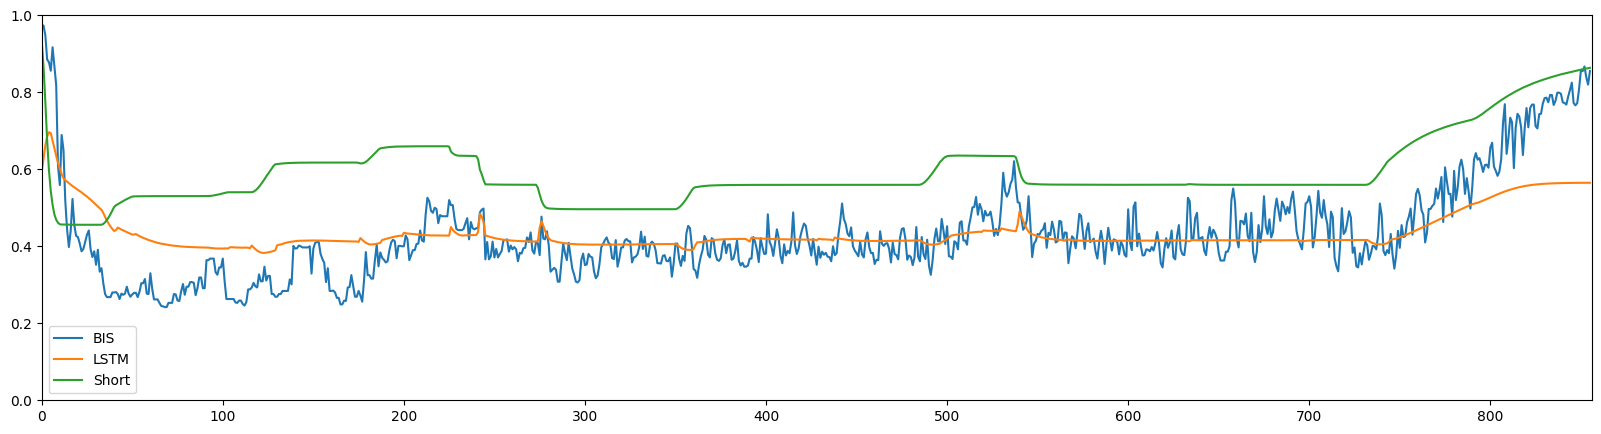

CaseID 5927, LSTM MAPE=19.227750778198242, Short MAPE=45.75341796875


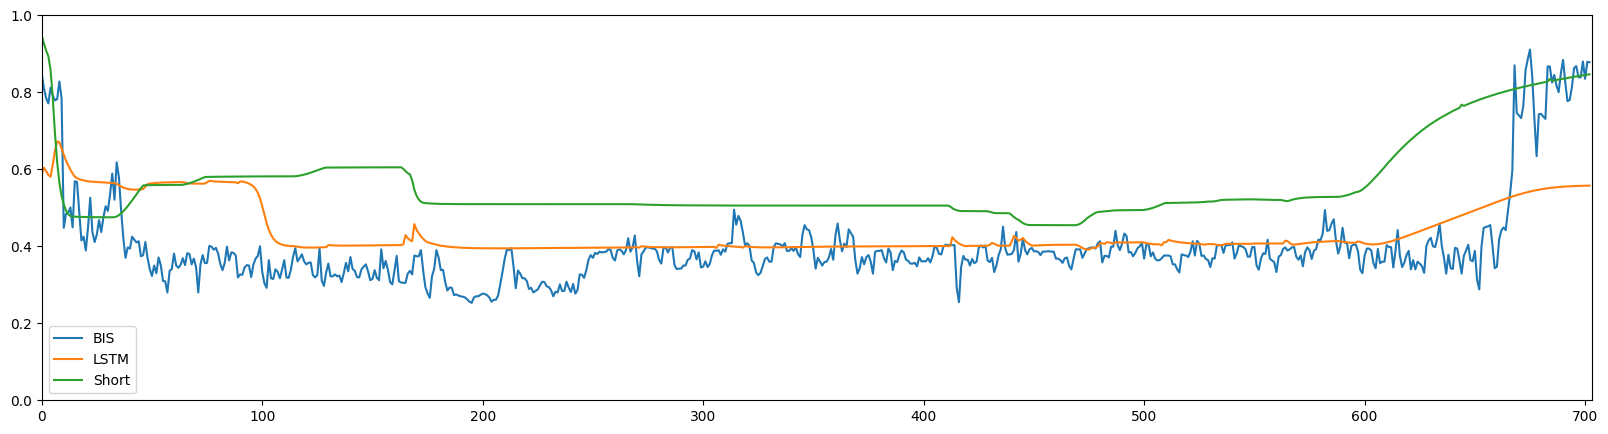

CaseID 6074, LSTM MAPE=20.985029220581055, Short MAPE=55.05100631713867


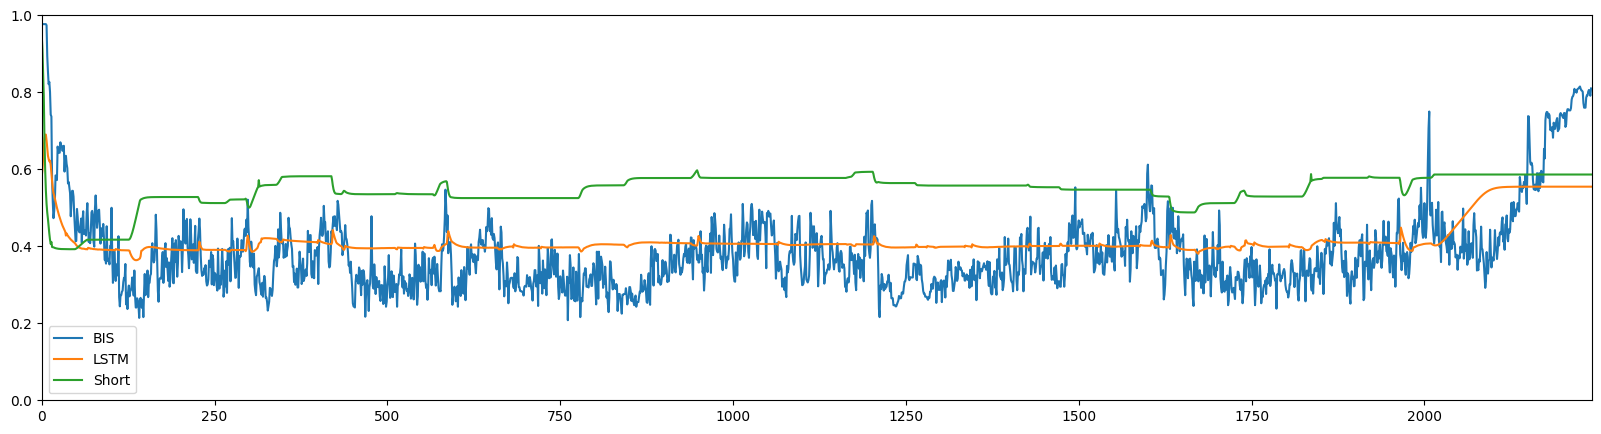

CaseID 6110, LSTM MAPE=15.10118579864502, Short MAPE=24.21625328063965


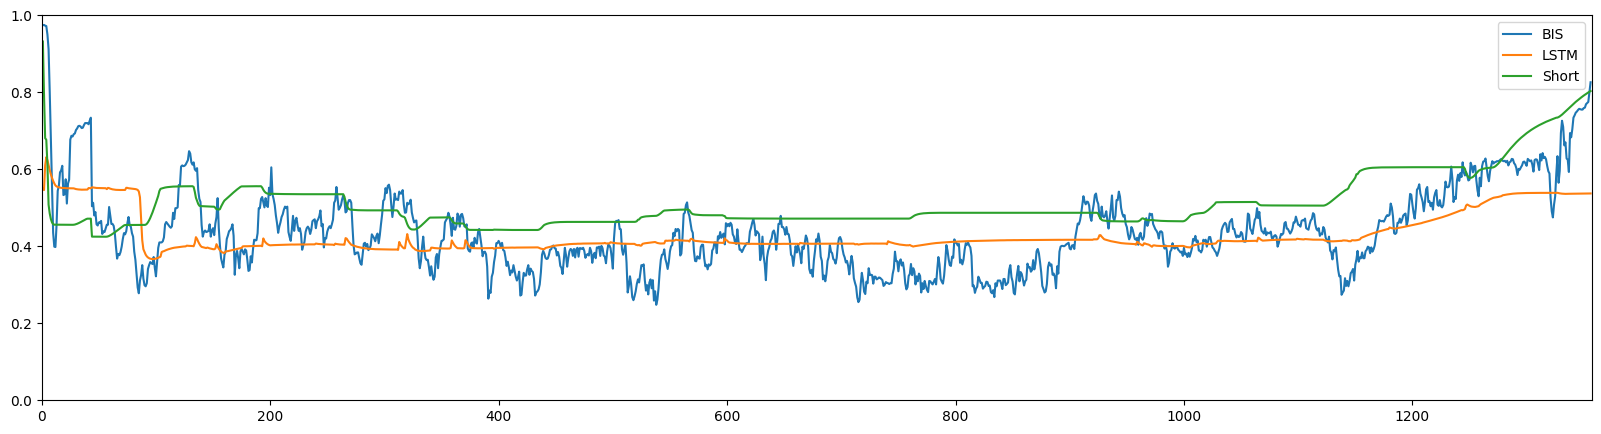

CaseID 6254, LSTM MAPE=21.51659393310547, Short MAPE=20.92193603515625


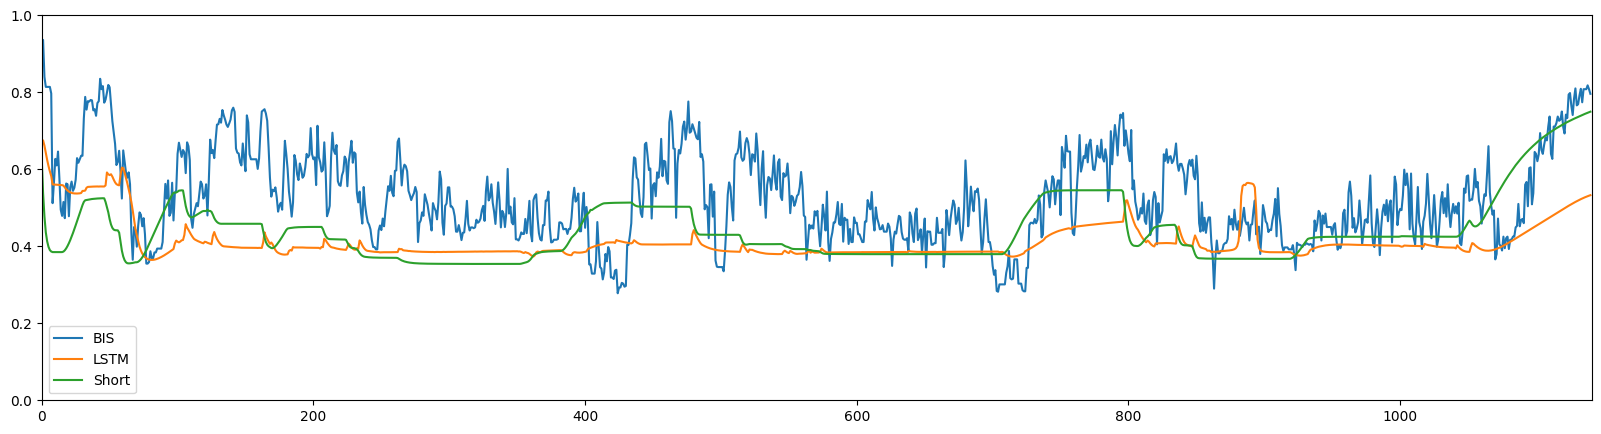

In [16]:
# Prediction
y_pred = model.predict(x_test).flatten()
print(f"Test MAPE (LSTM): {mape(y_test, y_pred):.1f}%")
print(f"Test MAPE (Short): {mape(y_test_old, y_pred):.1f}%")
print()

# Plotting
import matplotlib.pyplot as plt
for caseid in test_caseids:
    case_mask = (c[test_mask] == caseid)
    case_len = np.sum(case_mask)
    if case_len == 0:
        continue

    print('CaseID {}, LSTM MAPE={}, Short MAPE={}'.format(caseid, 
      mape(y_test[case_mask], y_pred[case_mask]), 
      mape(y_test[case_mask], y_test_old[case_mask])
      ))

    t = np.arange(0, case_len)
    plt.figure(figsize=(20, 5))
    plt.plot(t, y_test[case_mask], label='BIS')  # Ground truth
    plt.plot(t, y_pred[case_mask], label='LSTM')  # LSTM model
    plt.plot(t, y_test_old[case_mask], label='Short')  # Short model
    plt.legend()
    plt.xlim([0, case_len])
    plt.ylim([0, 1])
    plt.show()

In [70]:
from keras.layers import Attention

In [71]:
input_cov = Input(batch_shape=(None, 4))
input_ppf = Input(batch_shape=(None, LSTM_TIMEPOINTS, 1))
input_rft = Input(batch_shape=(None, LSTM_TIMEPOINTS, 1))

lstm_ppf = LSTM(LSTM_NODES, activation='tanh', return_sequences=True)(input_ppf)
lstm_rft = LSTM(LSTM_NODES, activation='tanh', return_sequences=True)(input_rft)

# Apply attention mechanism to LSTM outputs
attention_ppf = Attention()([lstm_ppf, lstm_ppf])
attention_rft = Attention()([lstm_rft, lstm_rft])

# Concatenate attention outputs with static features
output = concatenate([attention_ppf[:, -1, :], attention_rft[:, -1, :], input_cov])
output = Dense(FNN_NODES)(output)
output = Dropout(0.2)(output)
output = Dense(1, activation='sigmoid')(output)

model = Model(inputs=[input_ppf, input_rft, input_cov], outputs=[output])
model.compile(loss=mae, optimizer='adam', metrics=[mape])

# Train the model
hist = model.fit(x_train, y_train, validation_split=0.1, epochs=100, steps_per_epoch=100,
                           callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')])

# Get attention weights for a specific prediction
attention_model = Model(inputs=model.input, outputs=[model.layers[3].output, model.layers[4].output])
attention_weights_ppf, attention_weights_rft = attention_model.predict(x_test)


Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.1249 - mean_absolute_percentage_error: 31.6767 - val_loss: 0.0883 - val_mean_absolute_percentage_error: 21.8071
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0000e+00 - mean_absolute_percentage_error: 0.0000e+00 - val_loss: 0.0883 - val_mean_absolute_percentage_error: 21.8071
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0973 - mean_absolute_percentage_error: 23.6101 - val_loss: 0.0844 - val_mean_absolute_percentage_error: 20.9171
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0000e+00 - mean_absolute_percentage_error: 0.0000e+00 - val_loss: 0.0844 - val_mean_absolute_percentage_error: 20.9171
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0897 - mean_absolute_percentage_error: 23.5381 - val_loss: 0.0821 - val_mean_absolute_percentage_error: 20.9204
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0000e+00 - mean_absolute_percentage_error:

In [78]:
model.summary()

Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 180, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_23      │ (None, 180, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_14 (LSTM)      │ (None, 180, 8)    │        320 │ input_layer_22[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_15 (LSTM)      │ (None, 180, 8)    │        320 │ input_layer_23[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_8         │ (None, 180, 8)    │          0 │ lstm_14[0][0],    │
│ (Attention)         │                   │            │ lstm_14[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_9         │ (None, 180, 8)    │          0 │ lstm_15[0][0],    │
│ (Attention)         │                   │            │ lstm_15[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_8          │ (None, 8)         │          0 │ attention_8[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_9          │ (None, 8)         │          0 │ attention_9[0][0] │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_21      │ (None, 4)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 20)        │          0 │ get_item_8[0][0], │
│ (Concatenate)       │                   │            │ get_item_9[0][0], │
│                     │                   │            │ input_layer_21[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 16)        │        336 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 16)        │          0 │ dense_14[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 1)         │         17 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,981 (11.65 KB)

 Trainable params: 993 (3.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,988 (7.77 KB)

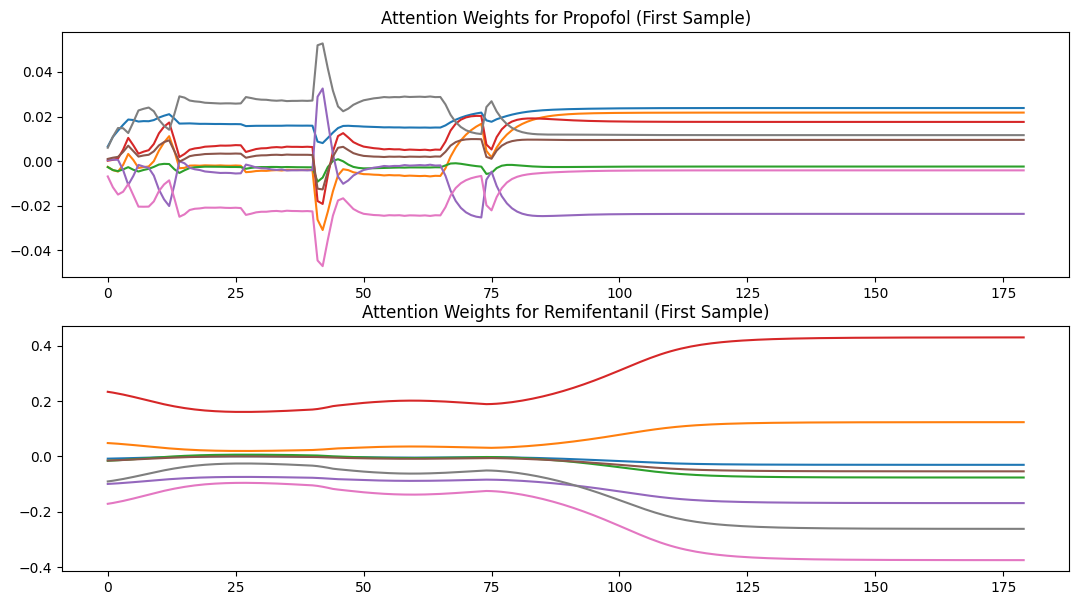

In [101]:
plt.figure(figsize=(13, 7))
plt.subplot(2, 1, 1)
plt.plot(attention_weights_ppf[0])
plt.title('Attention Weights for Propofol (First Sample)')

plt.subplot(2, 1, 2)
plt.plot(attention_weights_rft[0])
plt.title('Attention Weights for Remifentanil (First Sample)')
plt.show()


In [89]:
all_attention_weights_ppf[-2]

-0.0041748257

In [92]:
all_attention_weights_ppf = np.concatenate(all_attention_weights_ppf, axis=0)
all_attention_weights_rft = np.concatenate(all_attention_weights_rft, axis=0)


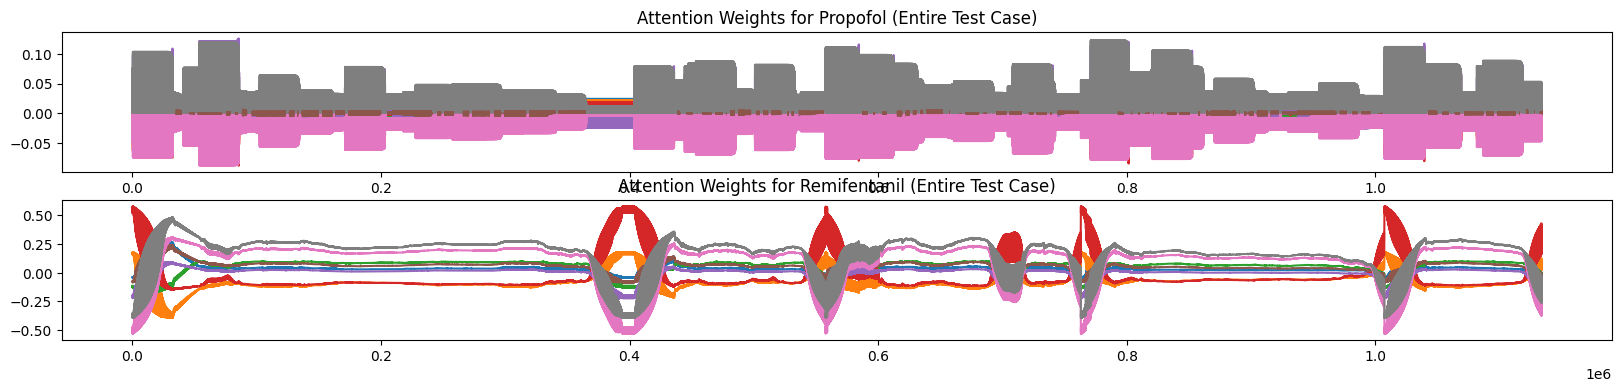

In [93]:
plt.figure(figsize=(20, 4)) 
plt.subplot(2, 1, 1)
plt.plot(all_attention_weights_ppf)
plt.title('Attention Weights for Propofol (Entire Test Case)')
plt.subplot(2, 1, 2)
plt.plot(all_attention_weights_rft)
plt.title('Attention Weights for Remifentanil (Entire Test Case)')
plt.show()

In [22]:
import lime
import lime.lime_tabular 

# ... (Your existing code) ...

# Create an explainer object 
explainer = lime.lime_tabular.LimeTabularExplainer(
    x_train,  # Your training data (you might need to reshape it)
    feature_names=['PPF Segment 1', 'PPF Segment 2', ..., 'RFT Segment 1', ...], 
    class_names=['BIS'], # Assuming you have a binary classification problem
    verbose=True, 
    mode='regression' # Since you are predicting a continuous value (BIS)
)

AttributeError: 'list' object has no attribute 'shape'

In [24]:
x_train_reshaped = np.concatenate((x_train[0].reshape(x_train[0].shape[0], -1), x_train[1].reshape(x_train[1].shape[0], -1), x_train[2]), axis=1)
x_test_reshaped = np.concatenate((x_test[0].reshape(x_test[0].shape[0], -1), x_test[1].reshape(x_test[1].shape[0], -1), x_test[2]), axis=1)

In [19]:
from keras.models import Model, load_model
from keras.layers import Dense, Dropout, LSTM, Input, concatenate
from keras.callbacks import EarlyStopping
import tensorflow as tf

# ... (your existing code) ... 

# Combine all inputs into a single list
combined_input = [input_ppf, input_rft, input_cov]

# ... (rest of your model definition) ...

# Create the model with the combined input and single output
model = Model(inputs=combined_input, outputs=output) 

In [27]:
def model_predict_wrapper(X):
  """Wrapper function to handle list input for SHAP."""
  return model.predict([X[:, :x_train[0].shape[1]].reshape(-1, x_train[0].shape[1], 1), 
                         X[:, x_train[0].shape[1]:x_train[0].shape[1]+x_train[1].shape[1]].reshape(-1, x_train[1].shape[1], 1),
                         X[:, x_train[0].shape[1]+x_train[1].shape[1]:]])

In [28]:
x_train_reshaped = np.concatenate((x_train[0].reshape(x_train[0].shape[0], -1), x_train[1].reshape(x_train[1].shape[0], -1), x_train[2]), axis=1)
x_test_reshaped = np.concatenate((x_test[0].reshape(x_test[0].shape[0], -1), x_test[1].reshape(x_test[1].shape[0], -1), x_test[2]), axis=1)

In [35]:
explainer = shap.DeepExplainer(model, x_aswh)


ValueError: Layer "functional_2" expects 3 input(s), but it received 1 input tensors. Inputs received: [array([[-1.97470037, -0.91141614,  1.37807116,  1.56668149],
       [-1.97470037, -0.91141614,  1.37807116,  1.56668149],
       [-1.97470037, -0.91141614,  1.37807116,  1.56668149],
       ...,
       [ 1.38451061,  1.09719365,  0.8532048 , -0.44562011],
       [ 1.38451061,  1.09719365,  0.8532048 , -0.44562011],
       [ 1.38451061,  1.09719365,  0.8532048 , -0.44562011]])]